# LeNet Implementation!

1. Create a LeNet Model
2. Feed in the Augmented data
3. Finalize!

### Import the necessary packages

In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string

import imghdr
from PIL import Image
from os import listdir


### Generate the LeNet Model!
**Requirements**
1. Input 32x32 image
2. Must adjust sizes if input is not 32x32

In [185]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 26)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv_layer(x)
        x = self.linear(x)
        return x


### Data handling

In [250]:
# Input: Path to a folder of .png files. Let #=dataset num, l = letter represented, v=variation, a=augmentation
#     Must be structured s.t. hand#_l_v_a.png
# Output: List of .png images and their respective labels
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []

    for image in imagesList:  # iterate over all images in the folder
        if imghdr.what(path + image) == 'png':
            if (image[6].isalpha()):  # 6th position is the letter
                img = Image.open(path + image)
                imgs.append(img)
                # assumes that filename structure is 'handx_[label]_....'
                labels.append(ord(image[6]) - ord('a'))
    return imgs, labels


# Process the data given input and output images.
# Input: all required arguments
# Note: LeNet assumes input of 32. Resize is hyperparameter based on dataset.

# def process_data(imgs, labels, batch_size=4, channels=3, resize=15, crop_size=32, test_split=0.2):
#   transforms_array = applyTransforms(imgs, channels, crop_size, resize=resize)
#   train_data, test_data, train_labels, test_labels = train_test_split(transforms_array, labels, test_size=test_split, random_state=42)
#   [trainloader, testloader] = train_test_loaders(train_data, train_labels, test_data, test_labels, batch_size)
#   return [trainloader, testloader]


# Input: the images list (3 channels), crop size, and resize hyperparameters
# Output: a tensor array of all the reshaped + resized images
def applyTransforms(imgs, crop_size, resize):
    # Define the necessary preprocessing transforms
    num_imgs = len(imgs)
    preprocess = transforms.Compose([
        transforms.Resize(resize),  # Hyperparameter
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
    ])

    # Create tensor array
    transforms_array = np.zeros((num_imgs, 3, crop_size, crop_size))
    for i in range(num_imgs):
        temp = preprocess(imgs[i])
        transforms_array[i, :, :, :] = temp

    return transforms_array

# Input: an image tensor [num_imgs, channels, x_dim, y_dim], test split, and a batch size
# Output: a tensor array of all the reshaped + resized images


# def train_dev_loaders(transforms_array, test_split=0.2, batch_size=4):
#     # Create the training dataand trainloader
#     train_data, dev_data, train_labels, dev_labels = train_test_split(
#         transforms_array, labels, test_size=test_split, random_state=42)
#     train_data_and_labels = []
#     for i in range(len(train_data)):
#         sample = (torch.Tensor(train_data[i, :, :, :]), train_labels[i])
#         train_data_and_labels.append(sample)

#     trainloader = torch.utils.data.DataLoader(train_data_and_labels, batch_size=batch_size,
#                                               shuffle=True, num_workers=2)

#     # Create the developmental data and devloader
#     dev_data_and_labels = []
#     for i in range(len(dev_data)):
#         sample = (torch.Tensor(dev_data[i, :, :, :]), dev_labels[i])
#         dev_data_and_labels.append(sample)

#     devloader = torch.utils.data.DataLoader(dev_data_and_labels, batch_size=batch_size,
#                                             shuffle=False, num_workers=2)
#     return [train_data, train_labels, trainloader, dev_data, dev_labels, devloader]

# Input: One normalized image
# Output: None
# Plots the image, assumed to be [3, x_dim, y_dim]


def imshow(img):
    # Unnormalize the image before showing!
    invTrans = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.],
                                                        std=[1/0.229, 1/0.224, 1/0.225]),
                                   transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                        std=[1., 1., 1.]),
                                   ])
    img = invTrans(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# Input: list of .png images, their labels, and other default parameters
# Output: None
# Plots the image, assumed to be [3, x_dim, y_dim]
def test_loader(test_data, test_labels, batch_size=4):
    # Create the testing data and testloader    
    test_data_and_labels = []
    for i in range(len(test_data)):
        sample = (torch.Tensor(test_data[i, :, :, :]), test_labels[i])
        test_data_and_labels.append(sample)

    testloader = torch.utils.data.DataLoader(test_data_and_labels, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

    test_labels = np.asarray(test_labels)
    return test_data, test_labels, testloader

# Input: an image tensor [num_imgs, channels, x_dim, y_dim], test split, and a batch size
# Output: a tensor array of all the reshaped + resized images
def train_dev_test_loaders(transforms_array, labels, test_split=0.2, batch_size=4):
  ## Create the training dataand trainloader
  train_data, dev_data, train_labels, dev_labels = train_test_split(transforms_array, labels, test_size=test_split, random_state=42)

  dev_data, test_data, dev_labels, test_labels = train_test_split(dev_data, dev_labels, test_size=0.5, random_state=42)

  train_data_and_labels = []
  for i in range(len(train_data)):
    sample = (torch.Tensor(train_data[i,:,:,:]), train_labels[i])
    train_data_and_labels.append(sample)

  trainloader = torch.utils.data.DataLoader(train_data_and_labels, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  ## Create the developmental data and devloader
  dev_data_and_labels = []
  for i in range(len(dev_data)):
    sample = (torch.Tensor(dev_data[i,:,:,:]), dev_labels[i])
    dev_data_and_labels.append(sample)

  devloader = torch.utils.data.DataLoader(dev_data_and_labels, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
  
  ## Create the Test data and testloader
  test_data_and_labels = []
  for i in range(len(test_data)):
    sample = (torch.Tensor(test_data[i,:,:,:]), test_labels[i])
    test_data_and_labels.append(sample)

  testloader = torch.utils.data.DataLoader(test_data_and_labels, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
  train_labels = np.asarray(train_labels)
  dev_labels = np.asarray(dev_labels)
  test_labels = np.asarray(test_labels)
  return [train_data, train_labels, trainloader, dev_data, dev_labels, devloader, test_data, test_labels, testloader]


In [187]:
import torch
import numpy as np
import torch.nn.functional as F


def accuracy(y : np.ndarray, y_hat : np.ndarray) -> np.float64:
    """Calculate the simple accuracy given two numpy vectors, each with int values
    corresponding to each class.

    Args:
        y (np.ndarray): actual value
        y_hat (np.ndarray): predicted value

    Returns:
        np.float64: accuracy
    """
    ### TODO Implement accuracy function
    N = len(y)   
    number_correct = N - np.count_nonzero(y - y_hat)
    accuracy = number_correct / N
    return accuracy


def approx_train_acc_and_loss(model, train_data : np.ndarray, train_labels : np.ndarray) -> np.float64:
    """Given a model, training data and its associated labels, calculate the simple accuracy when the 
    model is applied to the training dataset.
    This function is meant to be run during training to evaluate model training accuracy during training.

    Args:
        model (pytorch model): model class object.
        train_data (np.ndarray): training data
        train_labels (np.ndarray): training labels

    Returns:
        np.float64: simple accuracy
    """
    idxs = np.random.choice(len(train_data), 1, replace=False)
    x = torch.from_numpy(train_data[idxs].astype(np.float32))
    y = torch.from_numpy(train_labels[idxs])
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(train_labels[idxs], y_pred.numpy()), loss.item()


def dev_acc_and_loss(model, dev_data : np.ndarray, dev_labels : np.ndarray) -> np.float64:
    """Given a model, a validation dataset and its associated labels, calcualte the simple accuracy when the
    model is applied to the validation dataset.
    This function is meant to be run during training to evaluate model validation accuracy.

    Args:
        model (pytorch model): model class obj
        dev_data (np.ndarray): validation data
        dev_labels (np.ndarray): validation labels

    Returns:
        np.float64: simple validation accuracy
    """
    dev_labels = np.asarray(dev_labels)
    x = torch.from_numpy(dev_data.astype(np.float32))
    y = torch.from_numpy(dev_labels.astype(int))
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(dev_labels, y_pred.numpy()), loss.item()

In [188]:
# Train the model parameters
def train_model(trainloader, train_data, train_labels, dev_data, dev_labels, criterion, optimizer, model, num_images, n=20):

  for epoch in range(n):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        #   running_loss += loss.item()
        #   if i % print_schedule == (print_schedule-1):    # print every 200 mini-batches
        #       print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
        #       running_loss = 0.0
    
    if epoch % 2 == 0:
        train_acc, train_loss = approx_train_acc_and_loss(model, train_data, train_labels)
        dev_acc, dev_loss = dev_acc_and_loss(model, dev_data, dev_labels)
        step_metrics = {
                'step': epoch, 
                'train_loss': loss.item(), 
                'train_acc': train_acc,
                'dev_loss': dev_loss,
                'dev_acc': dev_acc
            }

        print(f"On step {epoch}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")

  print('Finished Training')

# Test the model on help out dev set
def test_model(testloader, model):
    correct = 0
    total = 0
    misclass_ind = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item() # Calculate number correct
            if ((predicted != labels).sum().item()) > 0:
                incorrect = predicted - labels
                for i in range(len(incorrect)):
                    if incorrect[i] != 0:
                        
                        misclass_ind.append(total + i)           
                    
            total += labels.size(0) # for each batch (size=4), predict the labels


    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

    return correct, total, misclass_ind

# Show number_batches * display_num images
def show_true_vs_predicted(testloader, classes, model, num_batches, batch_size):
    # print images
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_batches * batch_size)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_batches * batch_size)))



# Model Training: Data without Augmentation

In [189]:
# Step 1: Declare the model and associated classes
classes = list(string.ascii_uppercase)
lenet_no_aug = LeNet(len(classes))
batch_size = 4
channels = 3
xdim = 32
ydim = 32


In [190]:
# Step 2: Create the trainloader and testloader instances
path = "./Data_full/"
imgs, labels = loadImages(path)
print(f"Total number of images in Dataset is: {len(imgs)}")

transforms_array = applyTransforms(imgs, crop_size=32, resize=15)
[train_data, train_labels, trainloader, dev_data, dev_labels, devloader, test_data, test_labels, testloader] = train_dev_test_loaders(transforms_array, labels, test_split=0.2, batch_size=batch_size)


Total number of images in Dataset is: 650


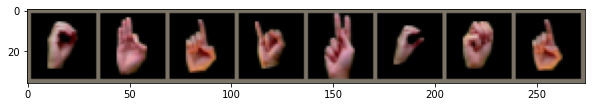

labels: O     F     D     I     K     C     M     D    


In [191]:
# Step 3: Visualize how some of the images look after processing the data
def visualize_images(trainloader, num_display, batch_size, xdim, ydim):
    dataiter = iter(trainloader)
    images = torch.empty((num_display * batch_size, channels, xdim, ydim))
    labels = torch.empty((num_display * batch_size), dtype=torch.uint8)
    #images, labels = dataiter.next()

    start_index = 0
    stop_index = batch_size
    for i in range(num_display):
        image, label = dataiter.next()
        images[start_index:stop_index, :, :, :] = image
        labels[start_index:stop_index] = label
        start_index = stop_index
        stop_index += batch_size

    imshow(torchvision.utils.make_grid(images))
    # print labels
    print("labels: " +
          ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_display * batch_size)))


visualize_images(trainloader, num_display=2,
                 batch_size=batch_size, xdim=xdim, ydim=ydim)


In [192]:
# Step 4: Declare the loss function and optimizer for training
lr = 0.001  # Too large suboptimal convergence. Too small is process gets stuck. Find a balance

lenet_no_aug = LeNet(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_no_aug.parameters(), lr=lr)


In [193]:

train_model(trainloader, train_data, train_labels, dev_data, dev_labels, criterion, optimizer,
            lenet_no_aug, num_images=len(train_data), n=20)


On step 0:	Train loss 3.0831527709960938	|	Dev acc is 0.24615384615384617
On step 2:	Train loss 0.49075785279273987	|	Dev acc is 0.8153846153846154
On step 4:	Train loss 0.008429542183876038	|	Dev acc is 0.9076923076923077
On step 6:	Train loss 0.009388227015733719	|	Dev acc is 0.9846153846153847
On step 8:	Train loss 5.936446541454643e-05	|	Dev acc is 1.0
On step 10:	Train loss 0.016368048265576363	|	Dev acc is 1.0
On step 12:	Train loss 0.0006883158930577338	|	Dev acc is 0.9846153846153847
On step 14:	Train loss 1.2636104656849056e-05	|	Dev acc is 1.0
On step 16:	Train loss 2.1219027985353023e-05	|	Dev acc is 1.0
On step 18:	Train loss 4.756337511935271e-05	|	Dev acc is 1.0
Finished Training


In [194]:
print("Evalating on the held-out test set...")
correct, total, misclass_ind = test_model(testloader, lenet_no_aug)

print(f"Correct: {correct} \nTotal: {total}")


Evalating on the held-out test set...
Accuracy of the network on the 65 test images: 100 %
Correct: 65 
Total: 65


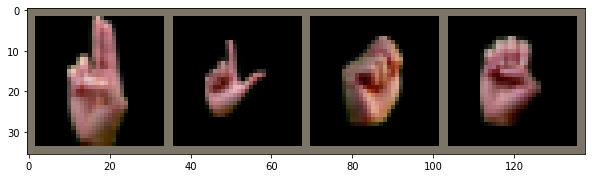

GroundTruth:  U     L     N     E    
Predicted:  U     L     N     E    


In [195]:
classes = list(string.ascii_uppercase)
show_true_vs_predicted(devloader, classes, lenet_no_aug,
                       num_batches=1, batch_size=batch_size)


In [196]:
# Visualize some incorrect values:
def show_incorrect(misclass_ind, images, labels, model, num_display=1):
    if len(misclass_ind) != 0:
        incorrect_imgs = torch.Tensor([images[i] for i in misclass_ind])
        true_labels = [labels[i] for i in misclass_ind]
        print(incorrect_imgs.shape)

        outputs = model(incorrect_imgs)
        _, predicted = torch.max(outputs, 1)

        incorrect_imgs = incorrect_imgs[:num_display, :, :, :]
        true_labels = true_labels[:num_display]
        predicted = predicted[:num_display]

        imshow(torchvision.utils.make_grid(incorrect_imgs))
        print("Actual labels: " +
              ' '.join(f'{classes[true_labels[j]]:5s}' for j in range(num_display)))
        print("predicted labels: " +
              ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_display)))


show_incorrect(misclass_ind, dev_data, dev_labels, lenet_no_aug)


In [197]:
# Save the model!
torch.save(lenet_no_aug.state_dict(), "./models/lenet_no_aug_650")


## Part 2: Apply on Data Augmentation Set

In [225]:
# Step 1: Declare the model and associated classes
classes = list(string.ascii_uppercase)
lenet_with_aug = LeNet(len(classes))
batch_size = 4
channels = 3
xdim = 32
ydim = 32


In [226]:
# Step 2: Create the trainloader and testloader instances
path = "./FinalImages/"
imgs, labels = loadImages(path)
print(f"Total number of images in Dataset is: {len(imgs)}")

transforms_array = applyTransforms(imgs, crop_size=32, resize=35)
[train_data, train_labels, trainloader, dev_data, dev_labels, devloader, test_data, test_labels, testloader] = train_dev_test_loaders(transforms_array, labels, test_split=0.2, batch_size=batch_size)


Total number of images in Dataset is: 3900


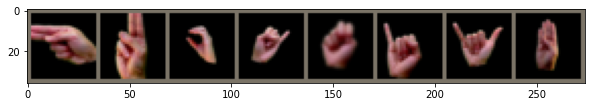

labels: H     U     C     J     N     I     Y     B    


In [227]:
# Step 3: Visualize how some of the images look after processing the data
visualize_images(trainloader, num_display=2,
                 batch_size=batch_size, xdim=xdim, ydim=ydim)


In [228]:
# Step 4: Declare the loss function and optimizer for training

lr = 0.001  # Too large suboptimal convergence. Too small is process gets stuck. Find a balance

lenet_with_aug = LeNet(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_with_aug.parameters(), lr=lr)


In [229]:
train_model(trainloader, train_data, train_labels, dev_data, dev_labels, criterion, optimizer,
            lenet_with_aug, num_images=len(train_data), n=20)


On step 0:	Train loss 0.12724940478801727	|	Dev acc is 0.5846153846153846
On step 2:	Train loss 0.0026977595407515764	|	Dev acc is 0.8153846153846154
On step 4:	Train loss 0.0006872437661513686	|	Dev acc is 0.841025641025641
On step 6:	Train loss 0.027923807501792908	|	Dev acc is 0.8692307692307693
On step 8:	Train loss 1.4781842764932662e-05	|	Dev acc is 0.8794871794871795
On step 10:	Train loss 1.8596476365928538e-05	|	Dev acc is 0.8358974358974359
On step 12:	Train loss 0.007620668038725853	|	Dev acc is 0.8871794871794871
On step 14:	Train loss 0.0007700338610447943	|	Dev acc is 0.8948717948717949
On step 16:	Train loss 0.000902007392141968	|	Dev acc is 0.8461538461538461
On step 18:	Train loss 2.3841855067985307e-07	|	Dev acc is 0.8692307692307693
Finished Training


In [230]:
print("Evalating on the held-out test set...")
correct, total, misclass_ind = test_model(testloader, lenet_with_aug)

print(misclass_ind)

print(f"Correct: {correct} \nTotal: {total}")


Evalating on the held-out test set...
Accuracy of the network on the 390 test images: 88 %
[12, 13, 40, 43, 49, 57, 66, 77, 93, 94, 102, 106, 107, 135, 154, 156, 172, 186, 190, 191, 195, 201, 205, 225, 232, 242, 256, 259, 262, 264, 267, 278, 287, 288, 316, 324, 327, 333, 347, 348, 353, 358, 359, 361, 380, 387]
Correct: 344 
Total: 390


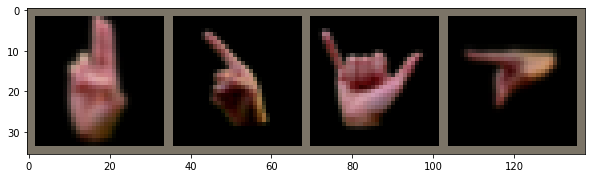

GroundTruth:  U     Z     Y     P    
Predicted:  U     Z     Y     P    


In [231]:
classes = list(string.ascii_uppercase)
show_true_vs_predicted(devloader, classes, lenet_with_aug,
                       num_batches=1, batch_size=batch_size)


<class 'numpy.ndarray'>


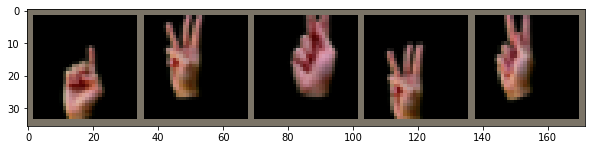

Actual labels: D     W     K     W     K    
predicted labels: M     V     R     I     V    


In [239]:
def show_incorrect(misclass_ind, images, labels, model, num_display=1):
    print(type(labels))
    incorrect_imgs = torch.Tensor(images[misclass_ind])
    true_labels = labels[misclass_ind]
    

    outputs = model(incorrect_imgs)
    _, predicted = torch.max(outputs, 1)

    idxs = np.random.choice(len(incorrect_imgs), num_display)

    incorrect_imgs = incorrect_imgs[idxs]
    true_labels = true_labels[idxs]
    predicted = predicted[idxs]

    imshow(torchvision.utils.make_grid(incorrect_imgs))
    print("Actual labels: " +
          ' '.join(f'{classes[true_labels[j]]:5s}' for j in range(num_display)))
    print("predicted labels: " +
          ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_display)))


show_incorrect(misclass_ind, test_data, test_labels,
               lenet_with_aug, num_display=5)


In [207]:
# Save the model!
torch.save(lenet_with_aug.state_dict(), f"./models/lenet_with_aug_3900")


### Part 3: Compare each model (trained with vs without augmented data) on newly augmented data

In [240]:
path = './Mult_Augments/'

test_imgs, test_labels = loadImages(path)

transforms_array_test_data = applyTransforms(test_imgs, crop_size=32, resize=35)
test_data, test_labels, testloader = test_loader(transforms_array_test_data, test_labels)


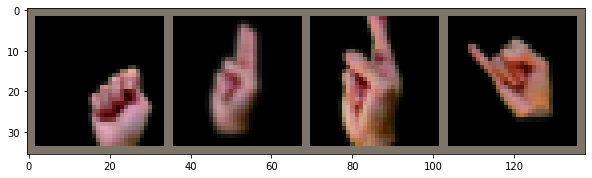

labels: T     U     R     J    


In [241]:
# Step 1: Visualize how some of the images look after processing the data
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [242]:
lenet_no_aug = LeNet(len(classes))
lenet_no_aug.load_state_dict(torch.load("./models/lenet_no_aug_650"))
lenet_no_aug.eval()


correct, total, misclass_ind = test_model(testloader, lenet_no_aug)


Accuracy of the network on the 650 test images: 32 %


In [243]:
lenet_with_aug = LeNet(len(classes))
lenet_with_aug.load_state_dict(torch.load("./models/lenet_with_aug_3900"))
lenet_with_aug.eval()

correct, total, misclass_ind = test_model(testloader, lenet_with_aug)


Accuracy of the network on the 650 test images: 70 %


### Trish Fish Second Folder

In [251]:
path = './Only_Mult_Augments/'

test_imgs, test_labels = loadImages(path)

transforms_array_test_data = applyTransforms(test_imgs, crop_size=32, resize=35)
test_data, test_labels, testloader = test_loader(transforms_array_test_data, test_labels)


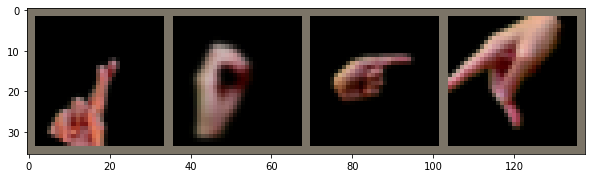

GroundTruth:  R     O     G     P    
Predicted:  Z     O     Q     W    


In [252]:
show_true_vs_predicted(testloader, classes, lenet_no_aug,
                       num_batches=1, batch_size=batch_size)

In [253]:
lenet_no_aug = LeNet(len(classes))
lenet_no_aug.load_state_dict(torch.load("./models/lenet_no_aug_650"))
lenet_no_aug.eval()


correct, total, misclass_ind = test_model(testloader, lenet_no_aug)

Accuracy of the network on the 650 test images: 17 %


In [254]:
lenet_with_aug = LeNet(len(classes))
lenet_with_aug.load_state_dict(torch.load("./models/lenet_with_aug_3900"))
lenet_with_aug.eval()

correct, total, misclass_ind = test_model(testloader, lenet_with_aug)




Accuracy of the network on the 650 test images: 59 %


<class 'numpy.ndarray'>


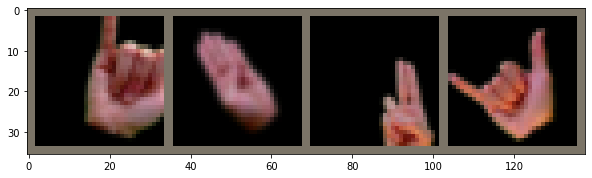

Actual labels: Y     B     U     Y    
predicted labels: B     E     F     L    


In [256]:
show_incorrect(misclass_ind, test_data, test_labels, lenet_with_aug, num_display=4)